<a href="https://colab.research.google.com/github/EbramMekhail/Electromyography-and-Gradient-Boosting/blob/main/EGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background and Documentation (30 points) 
#Electromyography and Gradient Boosting



## What is Gradient Boosting?

<br>

The best way to describe *Gradient Boosting* would the combination of multiple smaller models into a single composite model. In *Gradient Boosting* the method they use to create a single model is by taking the previous model and fitting it to the residual error made by the previous model.

The following equations describes the process.
1. $F_1(X) = y$ - Fitting Data into a model.
2. $h_1(X) = y - F_1(X)$ - Fitting the previous model to the residual error.
3. $F_2(X) = F_1(X) + h_1(X)$ - Creating a new model based on the previous model and the residual error
4. $F_{m+1}(X) = F_m(X) + h_m(X)$ - Repeats steps 2-3. The models residual error for m iterations: <br> $h_m(X) = y - F_m(X)$
   
---
## Heading in the right direction

In the previous section we explained how Gradient Boosting works weak models trained on previous models residual error $y-F_{m-1}(x)$. The issue arises when the model chases outliers. A counter to this issue would be to use a sign vector:
$sign(y_i - F_{m-1}(x_i))$ this will return one of the following $(-1,0,1)$.

## Loss Functions in Gradient Boosting

The most common loss function related to gradient boosting is :

$$ L(y, F_M(X)) = \frac{1}{N}\sum_{i=1}^N L(y_i, F_M(x_i)) $$

also for regression the function can be equivalent too:

$$ L(y, F_M(X)) = \frac{1}{N}\sum_{i=1}^N \left(y_i - F_M(x_i) \right)^2 $$

Next, to calculate the gradient for each $m\in 1, \ldots, M$ we can use the follow equation:

$$ r_{im} = - \left[ \frac{\partial L(y_i, F(x_i)}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)} \,, \qquad i = 1, \ldots , N$$

The previous equation is used for fitting a weak learner to the gradient components. To update the gradient descent we would have to use the following equation:

$$ F_{m+1}(X) = F_m(X) + \gamma_m h_m(X)$$

$\gamma_m$ in this situation would stand for the  learning rate or more specifically the shrinkage parameter that controllers how much each tree can contribute.

Finally we can use Mean Square Error since this algorithm is similar to the classification the only difference is we split the training data to minimize MSE instead originally we minimized the Gini Impurity.


$$J(k, t_k) = \frac{m_\mathrm{left}}{m}\mathrm{MSE}_\mathrm{left} + \frac{m_\mathrm{right}}{m}\mathrm{MSE}_\mathrm{right} $$

where 

$$ \mathrm{MSE}_\mathrm{node} = \sum_{i\in \mathrm{node}} \left(\hat{y}_\mathrm{node} - y^{(i)}\right)^2 
\qquad \mathrm{and} \qquad
\hat{y}_\mathrm{node} = \frac{1}{m_\mathrm{node}} \sum_{i\in \mathrm{node}} y^{(i)}
$$



In [ ]:
# ! git clone https://github.com/joelgrus/data-science-from-scratch
# ! mv data-science-from-scratch dsfs
! pip install --upgrade hepml


In [332]:
import pandas as pd
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))


#Coding from scratch using JAX (30 points)

First we generate the Data using the Equation given to us

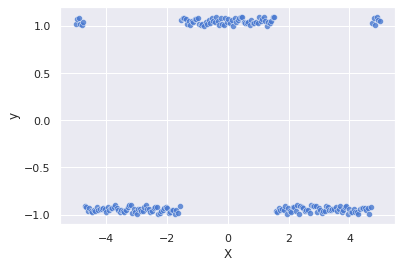

<Figure size 720x720 with 0 Axes>

In [423]:
from sklearn.model_selection import train_test_split
# set the number of examples
number_of_examples = 200

# fix the seed for reproducibility
seed = jrandom.PRNGKey(42)

# generate features
X = jnp.linspace(-5, 5, number_of_examples)

# generate target
y = jnp.array(list(map(lambda x: 1.0 if jnp.cos(x) >= 0 else -1.0, X)))
epsilon = 0.1
y += epsilon * jrandom.uniform(seed, shape=(200,))

# create pandas.DataFrame
data = pd.DataFrame(data=jnp.stack([X, y], axis=1), columns=["X", "y"])
data = data.astype({'X': float, 'y': float})

# print(data.head())
X = data[["X"]]
y = data[["y"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
X_train, y_train = X_train.sort_index(), y_train.sort_index()
X_test, y_test = X_test.sort_index(), y_test.sort_index()

sns.scatterplot(x="X", y="y", data=data, alpha=0.8)
plt.figure(figsize=(10, 10))
plt.show()


Using decision tree because of the issues we had using the method implmented from scratch in the book.

Then we just loop over it and feed it back the residuals. 

This is what a basic Gradient Boosting looks like 

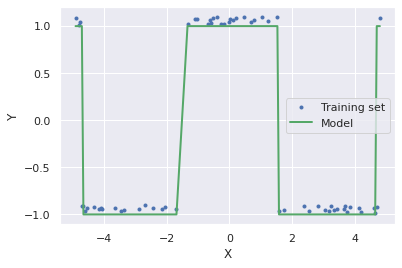

In [424]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

# model hyperparameters
n_trees = 10
max_depth = 1
y_train = jnp.round_(jnp.array(y_train)[:,0]).astype(int)
# Training
F0 = round(y_train.mean())
Fm = F0
trees = []
MSE = []
for _ in range(n_trees):
  tree = DecisionTreeClassifier(max_depth=max_depth)
  tree.fit(X_train, y_train - Fm)
  Fm += tree.predict(X_train)
  trees.append(tree)
    

# Prediction
y_hat = F0 + jnp.sum(jnp.array([t.predict(X_test) for t in trees]), axis=0)
y_hat = pd.DataFrame(y_hat, columns = ['y'])

label = 'Training set'
data_label = 'Model'
plt.ylabel("Y")
plt.xlabel("X")
plt.plot(X_test, y_test, "b.", label=label)
plt.plot(X_test, y_hat.sort_index(), "g-", linewidth=2, label=data_label)
if label or data_label:
  plt.legend(loc="right")

#EMG Dataset (40 points)


I mount the data from my drive since it was not downloadble any otherway.

If you would like to this colab notebook please download the data and change the data directories.

In [425]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [426]:
import os

actions = {}
# When Given the entire dataset the model over fits and the predictions become worse
data_dirs = ["/content/gdrive/MyDrive/Fall 2022/CS301/EMG Physical Action Data Set/sub1/Aggressive/txt/",
             "/content/gdrive/MyDrive/Fall 2022/CS301/EMG Physical Action Data Set/sub1/Normal/txt/"]

ind = 0
data = pd.DataFrame()

for dirs in data_dirs :

  for files in os.listdir(dirs):

    with open(os.path.join(dirs, files), "r") as f:  # from all the files within all the dirs, read the tab separated files.

     # Extracting the 8 columns names from filenames
      temp = pd.read_csv(f.name,
                        sep = "\t",
                        header = None, 
                        names = ["ch" + str(i) for i in range(1, 9)] # 8 input channels
                        )
      
      # chunking using Max of every 10 sequential values.
      temp_chunked = pd.DataFrame()

      for i in range(0, len(temp), 10):
        temp_chunked = temp_chunked.append(temp.iloc[i:i+10].max(), ignore_index = True)

      # Defining the class labels 

      labels = [files[:-4] for i in range(len(temp_chunked))] # remove the last 4 characters=".txt" from the filename to get the activity name
      actions[files[:-4]] = ind # We have about 20 activity classes and they are assigned a numeric labels in the actions dictionary.
      temp_chunked["Action"] = labels

      # Final Data pro
      data = pd.concat([data, temp_chunked])

      ind+=1


In [450]:
X=data.drop(["Action"], axis=1)
y=data["Action"]
y = y.map(actions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
print(y_train)

216    18
188    18
412     0
276     7
112     2
       ..
644    17
308     1
477    17
352     8
37     11
Name: Action, Length: 13797, dtype: int64


In [451]:
# model hyperparameters
n_trees = 200
max_depth = 7
# y_train = jnp.round_(jnp.array(y_train)[:,0])
# Training
F0 = round(y_train.mean()) 
Fm = F0
trees = []
for _ in range(n_trees):
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_train, y_train - Fm)
    Fm += tree.predict(X_train)
    trees.append(tree)

# Prediction
y_hat = F0 + jnp.sum(jnp.array([t.predict(X_test) for t in trees]), axis=0)

# print(y_hat)
y_test = y_test.to_numpy()

sum = 0
for i in range(len(y_hat)):
  if y_hat[i] == y_test[i]:
    sum +=1
print("Acc" , sum/len(y_hat))

Acc 0.46516739939127494
